<h1 align="center"> <strong>🔄 AdaBoost - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to AdaBoost (Adaptive Boosting), covering:
- Algorithm overview and key concepts
- How boosting works and AdaBoost's approach
- Implementation using scikit-learn
- Hyperparameter tuning
- Feature importance visualization
- Best practices and use cases

---

## **📚 1. Import Libraries and Setup**

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    mean_squared_error, r2_score, mean_absolute_error
)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **🔄 2. AdaBoost Algorithm Overview**

AdaBoost (Adaptive Boosting) is one of the first and most influential boosting algorithms, introduced by Yoav Freund and Robert Schapire in 1996. It won the prestigious Gödel Prize, which recognizes outstanding papers in theoretical computer science.

### **Key Concepts**

AdaBoost builds a strong learner by combining multiple weak learners (typically simple decision trees with one split, called "stumps"). The key insight of AdaBoost is that it:

1. **Focuses on hard examples**: It gives more weight to misclassified examples in subsequent iterations
2. **Weights models by performance**: Better performing models get more say in the final prediction

### **How Boosting Works**

Boosting is a sequential ensemble technique that works by:

1. Training models in sequence (not independently)
2. Each new model focuses on correcting the errors of previous models
3. Combining models with weighted voting

### **AdaBoost Algorithm Steps**

1. **Initialize weights**: Assign equal weights to all training examples (1/N)
2. **For each iteration t = 1, 2, ..., T**:
   - Train a weak learner (e.g., decision stump) on the weighted data
   - Calculate the weighted error of the model
   - Calculate model weight based on its error
   - Update data weights: increase for misclassified examples, decrease for correct ones
   - Normalize weights to form a valid distribution
3. **Final prediction**: Weighted majority vote of all weak learners

### **Mathematical View**

For each model $h_t$, the weight $\alpha_t$ is calculated as:

$$\alpha_t = \frac{1}{2} \ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$$

Where $\epsilon_t$ is the weighted error rate of model $h_t$.

The final prediction is:

$$H(x) = \text{sign}\left(\sum_{t=1}^{T} \alpha_t h_t(x)\right)$$

### **AdaBoost vs. Other Boosting Algorithms**

| Feature | AdaBoost | Gradient Boosting | XGBoost/LightGBM/CatBoost |
|---------|----------|-------------------|---------------------------|
| **Core Idea** | Reweighting examples | Gradient-based optimization | Advanced optimizations |
| **Loss Function** | Exponential loss | Flexible (usually MSE/Log loss) | Highly customizable |
| **Base Learners** | Usually decision stumps | Usually deeper trees | Configurable trees |
| **Regularization** | Limited | Some options | Extensive options |

## **📊 3. Use Cases and When to Use AdaBoost**

### **Ideal Use Cases**

AdaBoost works particularly well for:

- **Binary classification problems**: Its original design was for binary classification
- **Problems with mostly clean data**: Less robust to outliers and noisy data
- **Datasets where simple patterns can be useful**: AdaBoost's focus on hard examples can discover subtle patterns
- **As a baseline boosting algorithm**: Often used as a first boosting algorithm to try
- **When interpretability matters**: Simpler than more advanced boosting algorithms

### **When to Use AdaBoost vs. Other Algorithms**

- **Use AdaBoost when**:
  - You need a simple, easy-to-implement boosting algorithm
  - The dataset is relatively clean
  - You want a good balance of performance and interpretability
  - You're dealing with binary classification

- **Consider alternatives when**:
  - Dealing with large, complex datasets (→ XGBoost/LightGBM)
  - Working with categorical data (→ CatBoost)
  - Need more control over regularization (→ XGBoost)
  - Need faster training (→ LightGBM/XGBoost)

### **When NOT to Use AdaBoost**

- **With noisy data or many outliers**: AdaBoost tends to focus heavily on misclassified points, which can lead to overfitting on outliers
- **With very imbalanced classes**: Without proper adjustments, can perform poorly
- **When computational efficiency is critical**: Other boosting algorithms can be faster
- **For very large datasets**: More advanced methods scale better

## **📊 4. Generate Sample Data**

In [2]:
# Generate a synthetic classification dataset
X, y = make_classification( n_samples=1000,  n_features=20,  n_informative=10,  n_redundant=5,  n_classes=2,  random_state=42)

# Create a DataFrame for better visualization
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dataset shape: (1000, 21)

First 5 rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,1.470848,-0.360450,-0.591602,-0.728228,0.941690,1.065964,0.017832,-0.596184,1.840712,-1.497093,...,-0.603968,2.899256,0.037567,-1.249523,0.257963,0.416628,1.408208,-1.838041,-0.833142,1
1,4.513369,-2.227103,-1.140747,2.018263,-2.238358,-0.497370,0.714550,0.938883,-2.395169,0.159837,...,1.461499,3.954171,0.309054,0.538184,-7.157865,-4.532216,-0.081800,-9.325362,0.574386,1
2,-2.355643,2.218601,-1.603269,0.873394,0.401483,0.717264,-0.859399,-1.042190,-2.175965,0.980231,...,0.544434,-2.466258,-0.470256,0.073018,-2.203531,-2.299263,-1.742761,-0.271579,-0.359285,0
3,-1.596198,-0.857427,1.772434,-0.639361,1.419409,-0.438525,0.281949,2.345145,1.006230,0.389135,...,-1.025051,-2.422975,1.579807,-0.300713,4.267120,2.893775,1.236697,6.034785,-0.045711,0
4,2.840049,-2.489600,-0.844902,-1.594362,-4.688517,0.459637,0.913607,-1.143505,1.263937,-2.040928,...,4.176424,1.341742,0.133565,1.743819,1.531188,2.269808,0.053489,-3.151109,1.603702,0


## **🔧 5. Implementing AdaBoost with scikit-learn**

### **5.1 Classification Example**


--- AdaBoost Classification Results ---
Accuracy: 0.8160

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       133
           1       0.78      0.85      0.81       117

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



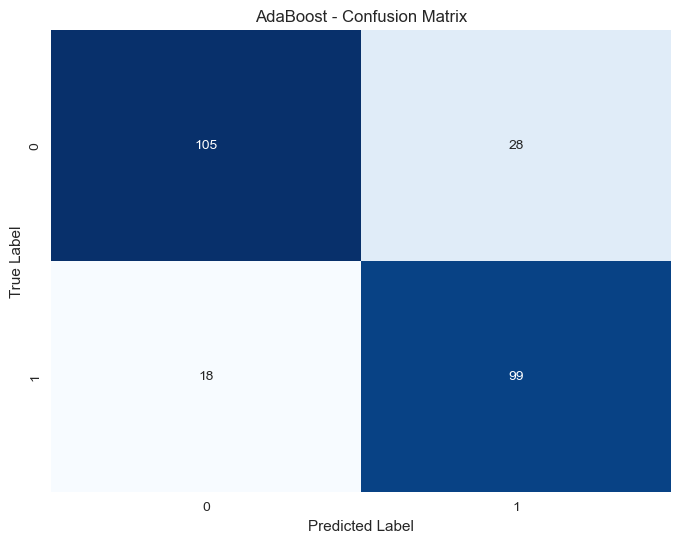

In [5]:
# Create and train an AdaBoost Classifier with decision stumps
# Decision stumps are decision trees with max_depth=1
base_estimator = DecisionTreeClassifier(max_depth=1)

ada_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,         # Number of weak learners
    learning_rate=1.0,       # Contribution of each classifier
    algorithm='SAMME',       # Use SAMME algorithm
    random_state=42
)

# Train the model
ada_clf.fit(X_train, y_train)

# Make predictions
y_pred = ada_clf.predict(X_test)
y_prob = ada_clf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("\n--- AdaBoost Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('AdaBoost - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **5.2 Regression Example**

--- AdaBoost Regression Results ---
R² Score: 0.7455
Mean Squared  Error : 9293.2975
Mean Absolute Error : 74.7871


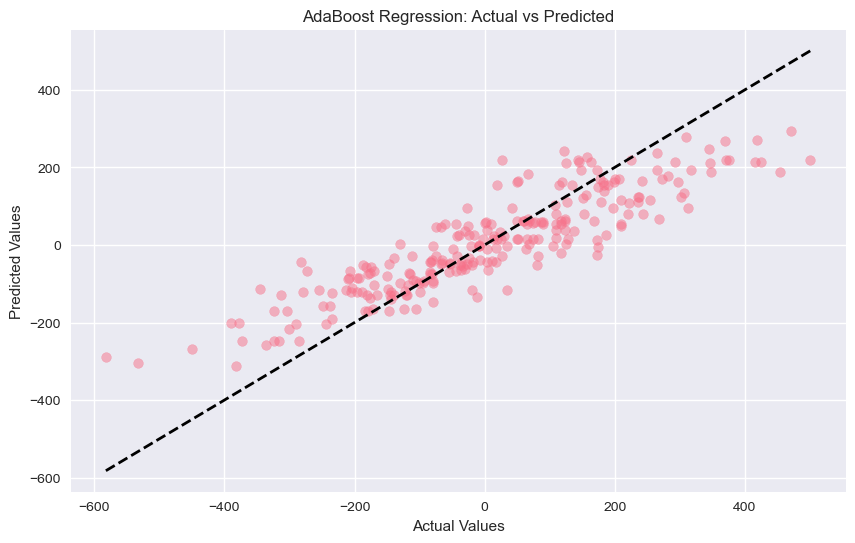

In [8]:
# Generate a synthetic regression dataset
X_reg, y_reg = make_regression( n_samples=1000,  n_features=20,  n_informative=10, noise=0.1, random_state=42)

# Split the regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# Create base estimator (decision tree with limited depth)
base_regressor = DecisionTreeRegressor(max_depth=3)

# Create and train an AdaBoost Regressor
ada_reg = AdaBoostRegressor( estimator=base_regressor, n_estimators=50, learning_rate=1.0, random_state=42)

# Train the model
ada_reg.fit(X_train_reg, y_train_reg)

# Make predictions
y_pred_reg = ada_reg.predict(X_test_reg)

# Evaluate the model
print("--- AdaBoost Regression Results ---")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared  Error : {mean_squared_error(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Absolute Error : {mean_absolute_error(y_test_reg, y_pred_reg):.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.title('AdaBoost Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

## **🔍 6. Key Hyperparameters Explained**

AdaBoost has several important hyperparameters that affect its behavior and performance:

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **n_estimators** | Number of weak learners (iterations) | 50-200 | Higher values may improve performance but risk overfitting |
| **learning_rate** | How much each learner contributes | 0.01-1.0 | Lower values need more estimators but may generalize better |
| **estimator** | The weak learner to boost | Decision stump (default) | More complex base models can improve performance but reduce the benefit of boosting |
| **algorithm** | Boosting algorithm variant | 'SAMME' or 'SAMME.R' | SAMME.R (default) uses probability estimates and usually performs better |

### **For AdaBoostClassifier Only**

- **algorithm**: 
  - 'SAMME': Original discrete boosting algorithm (Stagewise Additive Modeling using a Multi-class Exponential loss function)
  - 'SAMME.R': Uses real-valued prediction confidence (default and generally better)

### **Impact of Different Hyperparameter Values**

- **n_estimators**: 
  - Too few: Underfitting
  - Too many: Possible overfitting (though AdaBoost is relatively resistant) and longer training time

- **learning_rate**: 
  - High values (close to 1): Faster learning but potentially more unstable
  - Low values (0.01-0.1): Slower learning but potentially better generalization

- **estimator complexity**: 
  - Simple (e.g., stumps): More iterations needed but better interpretation of feature importance
  - Complex: Fewer iterations needed but may overfit

## **🔄 7. Hyperparameter Tuning**

In [10]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]  # Depth of the decision trees
}

# Create a base estimator (explicitly define for tuning the base estimator)
base_dt = DecisionTreeClassifier(random_state=42)

# Create the AdaBoost model
ada_model = AdaBoostClassifier(estimator=base_dt, random_state=42)

# Create a grid search object
grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search (Note: This may take some time to run)
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Display best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Create a model with the best parameters
best_ada = grid_search.best_estimator_

# Evaluate on the test set
best_predictions = best_ada.predict(X_test)
print(f"Test accuracy with best parameters: {accuracy_score(y_test, best_predictions):.4f}")

Starting grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 200}
Best cross-validation score: 0.9333
Test accuracy with best parameters: 0.9120
Best parameters: {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 200}
Best cross-validation score: 0.9333
Test accuracy with best parameters: 0.9120


## **📊 8. Feature Importance Visualization**

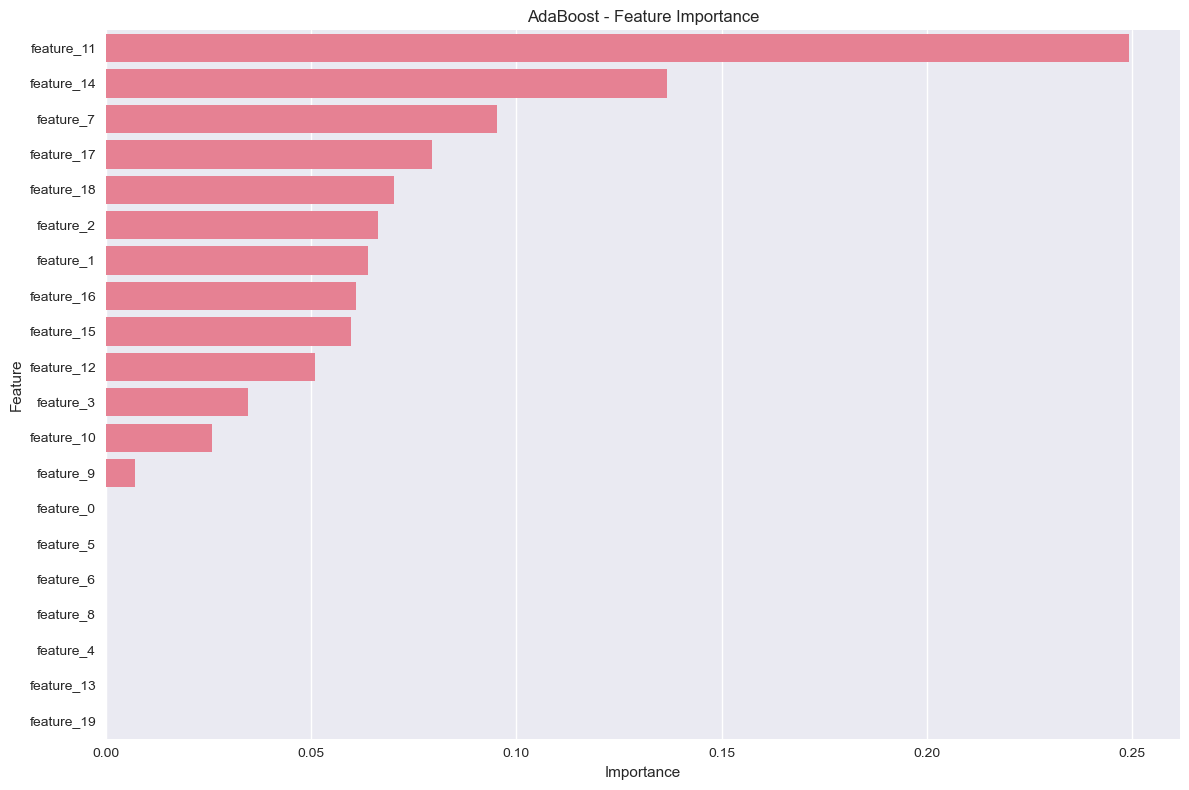

Top 10 Most Important Features:


,Feature,Importance
11,feature_11,0.249251
14,feature_14,0.136624
7,feature_7,0.095321
17,feature_17,0.079551
18,feature_18,0.070094
2,feature_2,0.066183
1,feature_1,0.063832
16,feature_16,0.061031
15,feature_15,0.059607
12,feature_12,0.050970


In [11]:
# Get feature importances from the trained model
feature_importances = ada_clf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('AdaBoost - Feature Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 Most Important Features:")
display(importance_df.head(10))

## **📈 9. Learning Curves**

Learning curves help us understand if our model is suffering from high bias (underfitting) or high variance (overfitting).

Training score (with full dataset): 0.9227
Validation score (with full dataset): 0.8480


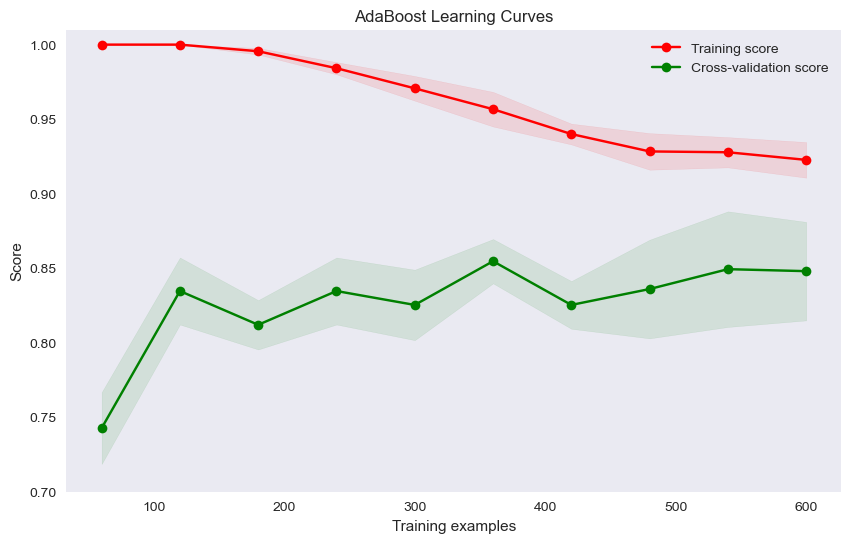

In [12]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title="Learning Curves", ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    # Print the final scores
    print(f"Training score (with full dataset): {train_scores_mean[-1]:.4f}")
    print(f"Validation score (with full dataset): {test_scores_mean[-1]:.4f}")
    
    return plt

# Plot learning curve for AdaBoost
plot_learning_curve(
    ada_clf, X_train, y_train, 
    title="AdaBoost Learning Curves",
    ylim=(0.7, 1.01))
plt.show()

## **🔄 10. Effect of Number of Estimators**

Let's see how model performance changes as we increase the number of estimators (weak learners).

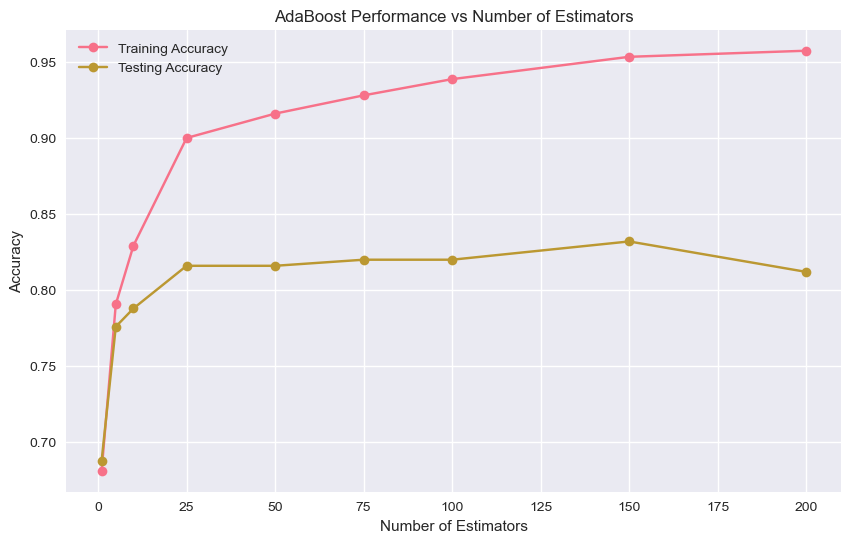

Best number of estimators : 150
Best test accuracy        : 0.83


In [13]:
# Range of estimators to try
n_estimators_range = [1, 5, 10, 25, 50, 75, 100, 150, 200]
train_scores = []
test_scores  = []

# Base estimator
base_model = DecisionTreeClassifier(max_depth=1, random_state=42)

# Train models with different numbers of estimators
for n_estimators in n_estimators_range:
    # Create and train the model
    model = AdaBoostClassifier(estimator=base_model,n_estimators=n_estimators,random_state=42)
    model.fit(X_train, y_train)
    
    # Record scores
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Training Accuracy')
plt.plot(n_estimators_range, test_scores, 'o-', label='Testing Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('AdaBoost Performance vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

# Find the best number of estimators
best_n_estimators = n_estimators_range[np.argmax(test_scores)]
print(f"Best number of estimators : {best_n_estimators}")
print(f"Best test accuracy        : {max(test_scores):.2f}")

## **💡 11. Best Practices and Tips**

### **When to Choose AdaBoost**

- **As a first boosting algorithm**: AdaBoost is simpler and often serves as a good baseline
- **For clean datasets**: Works well when data has minimal noise and outliers
- **When interpretability is needed**: Feature importance from AdaBoost is often intuitive
- **For binary classification**: Its original design was for binary problems

### **Tuning Tips**

1. **Start with defaults**: n_estimators=50, learning_rate=1.0 often work well
2. **n_estimators vs. learning_rate**: These have an inverse relationship
   - Lower learning rates require more estimators
   - A common practice is to set a small learning rate (0.01-0.1) and find the optimal n_estimators
3. **Base estimator complexity**: 
   - Decision stumps (max_depth=1) are the traditional choice
   - Slightly deeper trees (max_depth=2 or 3) can sometimes improve performance
4. **Watch out for overfitting**: Monitor validation performance as you increase n_estimators

### **Practical Considerations**

- **For imbalanced datasets**: AdaBoost naturally focuses on hard-to-classify examples, which can help with imbalanced data
- **Memory usage**: Generally low compared to other ensemble methods
- **Training time**: Can be slow for large datasets or many estimators
- **Prediction time**: Scales with number of estimators but is generally fast

### **Common Pitfalls**

- **Sensitivity to outliers**: AdaBoost gives higher weight to misclassified points, which can overfit to outliers
- **Limited by weak learner**: If base estimator is too simple, AdaBoost may underfit
- **Stopping too early**: Too few estimators may result in underfitting
- **Not trying other boosting algorithms**: More modern boosting algorithms often outperform AdaBoost

## **📚 12. Additional Resources**

### **Papers**

- [A Short Introduction to Boosting](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf) - Original paper by Freund and Schapire
- [Experiments with a New Boosting Algorithm](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=97f28e34e6373f831132e5d1ac3bed4e457fd86b) - The paper introducing AdaBoost

### **Documentation**

- [Scikit-learn AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [Scikit-learn AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

### **Tutorials and Guides**

- [Scikit-learn Ensemble Methods Guide](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)
- [Understanding AdaBoost](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe)

---

<h3 align="center">🔄 Happy Modeling with AdaBoost! 🔄</h3>